In [11]:
!pip install opencv-python scikit-image matplotlib ultralytics ffmpeg-python

This is a test notebook that intends to show how compression might affect object detection.

## Downloading Dataset

I will test using the VIRAT Video Dataset. This dataset contains surveillance-sstyle videos with people, vehicles and activities. It also has annotations of bounding boxes and activities.

In [12]:
import os
import zipfile
import urllib.request

In [13]:
url = "https://data.kitware.com/api/v1/item/56f5825c8d777f753209ca47/download?contentDisposition=inline"
output_path = 'file.mp4'
extract_directory = './dataset'

In [14]:
urllib.request.urlretrieve(url, output_path)
print("Download complete.")

Download complete.


In [15]:
ORIGINAL_VIDEO = "/content/file.mp4"

## Compression

In [16]:
import ffmpeg

In [19]:
def compress_video(input_path, output_path, codec='libx264', crf=23):
  ffmpeg.input(input_path).output(output_path, vcodec=codec, crf=crf).run()

In [20]:
compressed_h264 = "compressed_h264.mp4"
compress_video(ORIGINAL_VIDEO, compressed_h264, codec="libx264", crf=23)

## Frame Extraction

In [21]:
import cv2
import matplotlib.pyplot as plt

In [22]:
def extract_frames(video_path, out_dir):
  os.makedirs(out_dir, exist_ok=True)
  cap = cv2.VideoCapture(video_path)
  frame_idx = 0;
  while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
      break
    cv2.imwrite(f"{out_dir}/frame_{frame_idx:04d}.png", frame)
    if frame_idx == 0: #display the first frame
      plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) #convert from BGR to RGB
      plt.show()
    frame_idx += 1
  cap.release()

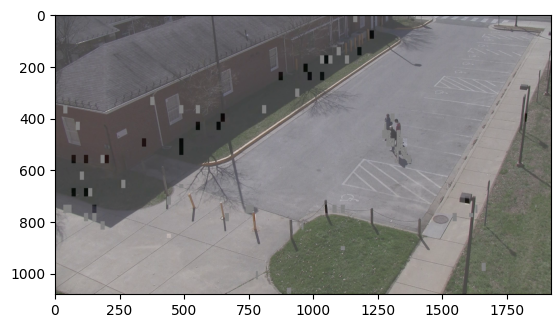

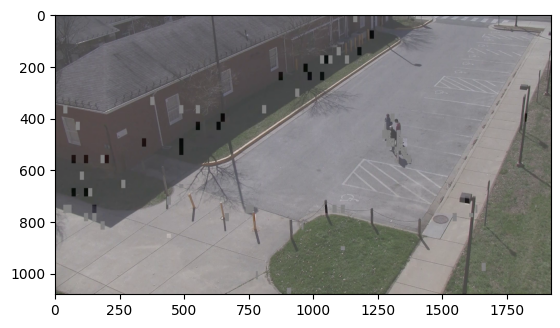

In [23]:
extract_frames(ORIGINAL_VIDEO, "frames/original")
extract_frames(compressed_h264, "frames/h264")

## Object Detection

In [24]:
from ultralytics import YOLO

In [26]:
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 77.4MB/s]


In [30]:
def run_detection(image_path):
  result = model(image_path)
  return result[0].boxes.xyxy.cpu().numpy()

In [37]:
boxes = run_detection("frames/original/frame_0000.png") # Test on one frame


image 1/1 /content/frames/original/frame_0000.png: 384x640 1 person, 154.3ms
Speed: 3.4ms preprocess, 154.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


## Artifact Visualization

In [32]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

In [33]:
def compute_ssim(img1_path, img2_path):
  img1 = cv2.imread(img1_path)
  img2 = cv2.imread(img2_path)
  score, diff = ssim(img1, img2, full=True, channel_axis=2)
  diff = (diff * 255).astype("uint8")
  return score, diff

In [34]:
def draw_boxes(img_path, boxes):
  img = cv2.imread(img_path)
  for box in boxes:
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
  return img[..., ::-1] # BGR to RGB

In [35]:
original_img = draw_boxes("frames/original/frame_0000.png", run_detection("frames/original/frame_0000.png"))
h264_img = draw_boxes("frames/h264/frame_0000.png", run_detection("frames/h264/frame_0000.png"))
ssim_score, diff = compute_ssim("frames/original/frame_0000.png", "frames/h264/frame_0000.png")


image 1/1 /content/frames/original/frame_0000.png: 384x640 1 person, 239.7ms
Speed: 4.7ms preprocess, 239.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/frames/h264/frame_0000.png: 384x640 1 person, 235.4ms
Speed: 4.7ms preprocess, 235.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


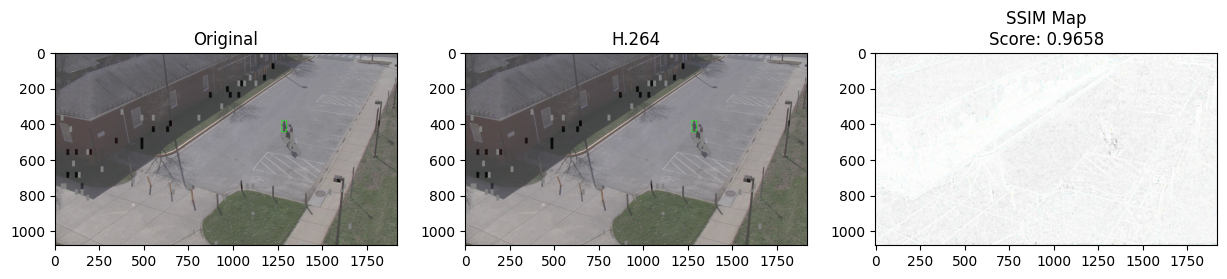

In [38]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(original_img); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(h264_img); plt.title("H.264")
plt.subplot(1,3,3); plt.imshow(diff, cmap='gray'); plt.title(f"SSIM Map\nScore: {ssim_score:.4f}")
plt.show()